# Electrode Expansion
Plot expansion for UM battery lab pouch cell parameters

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"

%matplotlib widget

# Expansion Functions and other Battery Parameters

In [2]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0,
            # Initializing Particle Concentration
            # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
            # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

# Define Experiment and Model

In [3]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
c_rate_c = 'C/20'
c_rate_d = 'C/20'
dis_set = " until 3V"
experiment = pybamm.Experiment(
    [
        # "Discharge at "+c_rate_d+dis_set,
        # "Rest for 5 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
spm = pybamm.lithium_ion.SPM(
    {
        "particle mechanics": "swelling only",
    }
)

# Chose Cell for Simulation

In [4]:
cell = 1

## Load eSOH Data and OCV Data

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 41, 59, 98, 134, 175, 216, 257, 298, 339, 380


## Chose cycle to simulate from the above cycle numbers

In [6]:
cyc_no = 0

In [7]:
dfo = dfo_0[dfo_0['N']==N[cyc_no]]
# dfe_0 = dfe[dfe['N']==N[cyc_no]]
C_n_init = dfe['C_n'][cyc_no]
C_p_init = dfe['C_p'][cyc_no]
y_0_init = dfe['y_0'][cyc_no] 

In [8]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial concentration in positive electrode [mol.m-3]": cs_p_init,
    },
    check_already_exists=False,
)

# Run Simulation

In [9]:
sol = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol = sol.solve()

In [10]:
# spm.variable_names()
# spm.variables.search("capacity")
# parameter_values.search("concentration")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
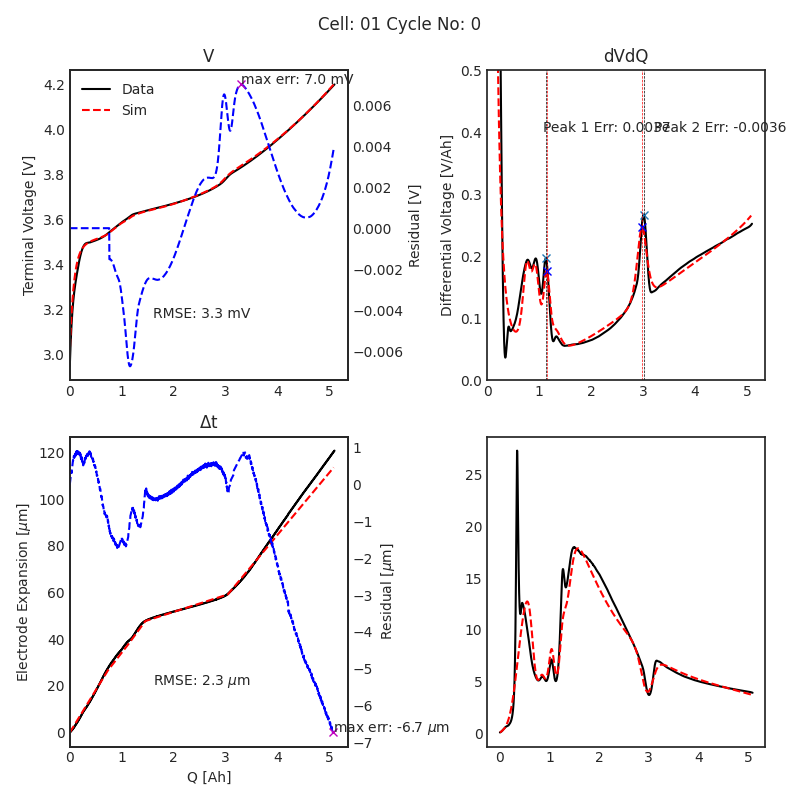

In [11]:
Q = -sol['Discharge capacity [A.h]'].entries
Vt = sol["Terminal voltage [V]"].entries
exp = 30e6*sol["Cell thickness change [m]"].entries
window_length=501
polyorder=5
Qf_d = savgol_filter(dfo['Q'],window_length,polyorder)
dQ_d = savgol_filter(dfo['Q'],window_length,polyorder,1)
Vf_d = savgol_filter(dfo['V'],window_length,polyorder)
dV_d = savgol_filter(dfo['V'],window_length,polyorder,1)
Ef_d = savgol_filter(dfo['E'],window_length,polyorder)
dQ2_d = savgol_filter(dfo['Q'],window_length,polyorder,2)
dE2_d = savgol_filter(dfo['E'],window_length,polyorder,2)
window_length=51
polyorder=5
Qf_s = savgol_filter(Q,window_length,polyorder)
dQ_s = savgol_filter(Q,window_length,polyorder,1)
Vf_s = savgol_filter(Vt,window_length,polyorder)
dV_s = savgol_filter(Vt,window_length,polyorder,1)
Ef_s = savgol_filter(exp,window_length,polyorder)
dQ2_s = savgol_filter(Q,window_length,polyorder,2)
dE2_s = savgol_filter(exp,window_length,polyorder,2)
Q_filt = ((Q/max(Q))>0.15)
int_V = interpolate.CubicSpline(Qf_d,Vf_d,extrapolate=True)
rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
V_err = Vt*Q_filt-int_V(Q)*Q_filt
V_max_loc = np.argmax(abs(V_err))
V_err_Q = Q[V_max_loc]
V_err_max = V_err[V_max_loc]
int_E = interpolate.CubicSpline(dfo['Q'],dfo['E']-dfo['E'].iloc[0],extrapolate=True)
rmse_E = pybamm.rmse(exp,int_E(Q))
E_err = exp-int_E(Q)
E_max_loc = np.argmax(abs(E_err))
E_err_Q = Q[E_max_loc]
E_err_max = E_err[E_max_loc]


dVdQ_d = dV_d/dQ_d
dVdQf_d = dVdQ_d*(dVdQ_d>0.16)
dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.1,width=0.1,prominence=0.01)
dV_peaks_d = dV_peaks_d[-2:]
dVdQ_s = dV_s/dQ_s
dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
dV_peaks_s = dV_peaks_s[-2:]  

dQdV_d = dQ_d/dV_d
dQdV_s = dQ_s/dV_s

plt.figure(figsize=[8,8])
ax1 =plt.subplot(2,2,1)
ax1.plot(Qf_d,Vf_d,'k')
ax1.plot(Q,Vt,'r--')
ax1.legend(['Data' , 'Sim'])
ax1.text(0.3,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
ax1.set_ylabel('Terminal Voltage [V]')
ax1.set_title('V')
ax1.set_xlim(left=0)
ax11 = ax1.twinx()
ax11.plot(Q,V_err,'b--')
ax11.plot(V_err_Q,V_err_max,'mx')
ax11.text(V_err_Q,V_err_max,f'max err: {V_err_max*1e3:0.1f} mV')
ax11.set_ylabel('Residual [V]')
ax2 = plt.subplot(2,2,2)
ax2.plot(Qf_d,dVdQ_d,'k')
ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'x')
ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5)
ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5)
ax2.plot(Qf_s,dVdQ_s,'r--')
ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5)
peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5)
peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
ax2.set_title('dVdQ')
ax2.set_ylabel('Differential Voltage [V/Ah]')
ax2.set_ylim([0,0.5])
ax2.set_xlim(left=0)
ax3 = plt.subplot(2,2,3)
ax3.plot(dfo['Q'], dfo['E']-dfo['E'].iloc[0],'k')
ax3.plot(Q,exp,'r--')
ax3.text(0.3,0.2,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax3.transAxes)
ax3.set_xlim(left=0)
ax3.set_xlabel('Q [Ah]')
ax3.set_ylabel('Electrode Expansion [$\mu$m]')
ax3.set_title('$\Delta$t')
ax31 = ax3.twinx()
ax31.plot(Q,E_err,'b--')
ax31.plot(E_err_Q,E_err_max,'mx')
ax31.text(E_err_Q,E_err_max,f'max err: {E_err_max:0.1f} $\mu$m')
ax31.set_ylabel('Residual [$\mu$m]')
ax4 = plt.subplot(2,2,4)
ax4.plot(Qf_d,dQdV_d,'k')
ax4.plot(Qf_s,dQdV_s,'r--')
plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
plt.tight_layout()
# plt.savefig(fig_DIR +'sim_'+cell_no+'_cyc_'+str(N[cyc_no]))